In [8]:
import time
import os
import networkx as nx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from scipy.spatial import KDTree
from tqdm import tqdm
from math import ceil
from itertools import cycle
from collections import deque, defaultdict

In [9]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None


    def fit(self, X):
        n = X.shape[0]
        self.labels_ = np.full(n, -1)
        cluster_id = 0
        tree = KDTree(X)
        for i in range(n):
            if self.labels_[i] != -1:
                continue
            neighbors = tree.query_ball_point(X[i], r=self.eps)
            if len(neighbors) < self.min_samples:
                continue
            self.labels_[i] = cluster_id
            queue = list(neighbors)
            while queue:
                j = queue.pop(0)
                if self.labels_[j] == -1:
                    self.labels_[j] = cluster_id
                if self.labels_[j] != -1:
                    continue
                self.labels_[j] = cluster_id
                new_neighbors = tree.query_radius([X[j]], r=self.eps)[0]
                if len(new_neighbors) >= self.min_samples:
                    queue.extend(new_neighbors)
            cluster_id += 1
        return self

In [10]:
INPUT_FILE = 'data1.csv'

df = pd.read_csv(INPUT_FILE)
df['Дата/Время'] = pd.to_datetime(df['Дата/Время'])
df = df.sort_values('Дата/Время')

df = df.iloc[0:10000]

<ipython-input-10-e4329a6eca5b>:4: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Дата/Время'] = pd.to_datetime(df['Дата/Время'])


Всего точек: 10,000
Кластеров: 479
Шумовых точек: 150 (1.5%)


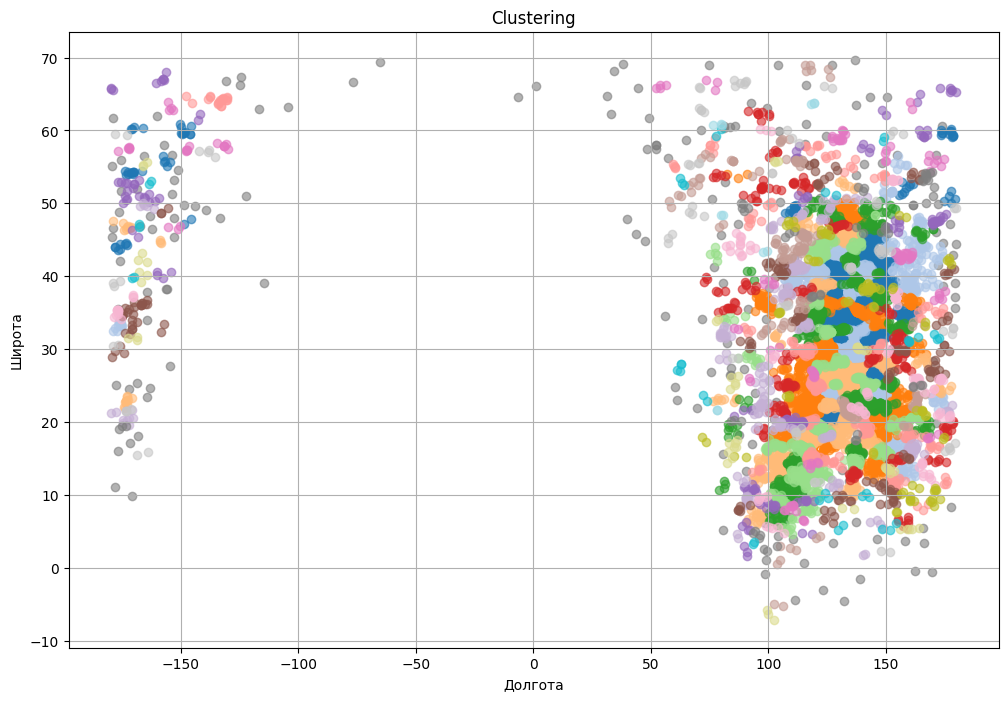


Результаты сохранены в файл: clustered_data.csv


In [11]:
OUTPUT_FILE = 'clustered_data.csv'
EPS = 0.1
MIN_SAMPLES = 2
MIN_CLUSTER_SIZE = 2

coords = df[['Долгота', 'Широта']].values
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(coords)
df['cluster'] = dbscan.labels_

cluster_sizes = df[df['cluster'] != -1].groupby('cluster').size()
small_clusters = cluster_sizes[cluster_sizes < MIN_CLUSTER_SIZE].index
df.loc[df['cluster'].isin(small_clusters), 'cluster'] = -1

noise = df[df['cluster'] == -1]
clustered_df = df[df['cluster'] != -1]
n_clusters = len(clustered_df['cluster'].unique())


noise = df[df['cluster'] == -1]
clustered_df = df[df['cluster'] != -1]
n_clusters = len(clustered_df['cluster'].unique())

print(f"Всего точек: {len(df):,}")
print(f"Кластеров: {n_clusters}")
print(f"Шумовых точек: {len(noise):,} ({len(noise)/len(df):.1%})")

plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(set(dbscan.labels_))))

for cluster_id, color in zip(sorted(set(dbscan.labels_)), colors):
    if cluster_id == -1:
        color = 'gray'
    cluster_df = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_df['Долгота'],
                cluster_df['Широта'],
                color=color,
                label=f'Cluster {cluster_id}',
                alpha=0.6)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Clustering')
plt.grid(True)
plt.show()
df.to_csv(OUTPUT_FILE, index=False)
print(f"\nРезультаты сохранены в файл: {OUTPUT_FILE}")
plt.show()

In [15]:
df = pd.read_csv('clustered_data.csv')
df['Дата/Время'] = pd.to_datetime(df['Дата/Время'])
df = df.sort_values('Дата/Время')
df.head()

,Ключ,Дата/Время,Долгота,Широта,cluster
0,3,2019-03-19 08:18:00,158.442827,34.844042,0
1,8,2019-03-19 08:18:00,-173.917789,44.376999,1
2,384,2019-03-19 08:19:00,-145.796176,47.889858,2
3,129,2019-03-19 08:19:00,179.331607,50.629030,3
4,266,2019-03-19 08:19:00,149.430243,39.345831,4


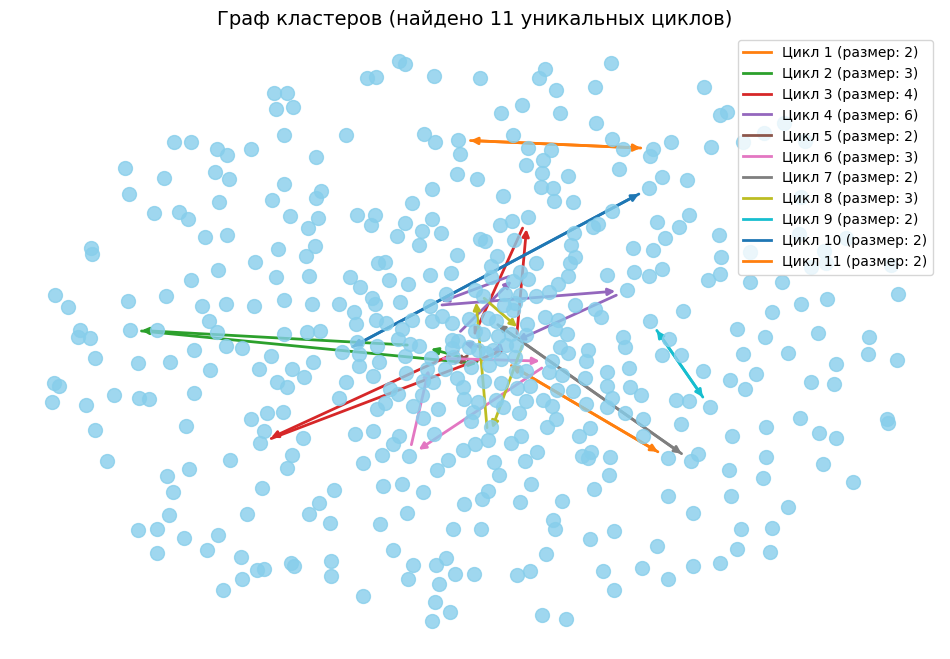

Найдено уникальных циклов: 11


Визуализация циклов: 100%|██████████| 11/11 [00:00<00:00, 28.91it/s]


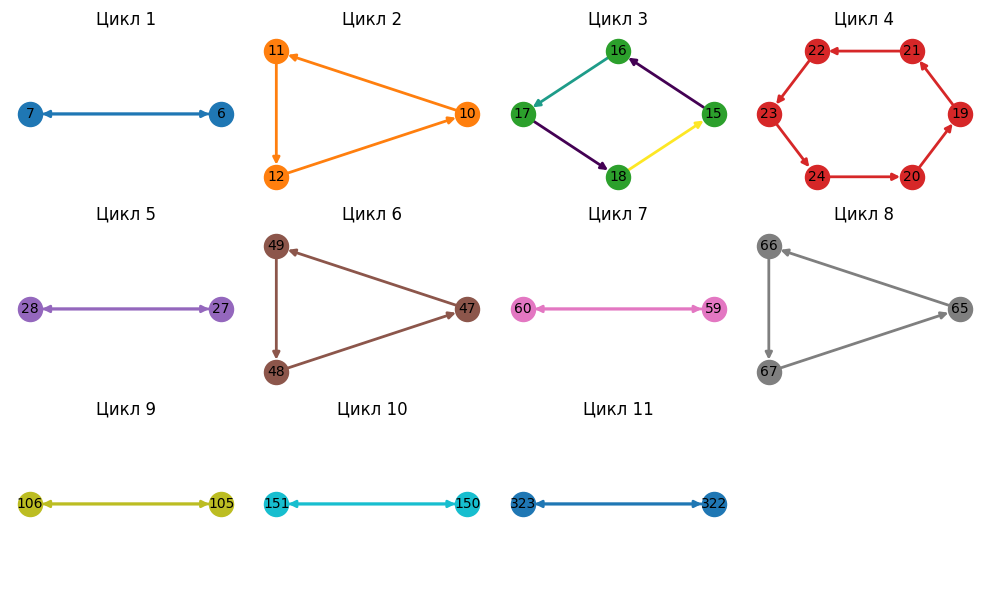

In [16]:
G = nx.DiGraph()
unique_cycles = []
edge_color_map = {}

for i in range(len(df) - 1):
    current = df.iloc[i]['cluster']
    next_ = df.iloc[i + 1]['cluster']
    if current == -1 or next_ == -1:
        continue
    if current != next_:
        edge = (current, next_)
        if not G.has_edge(*edge):
            G.add_edge(*edge)
            try:
                cycle_edges = nx.find_cycle(G, source=next_, orientation='original')
                nodes = [edge[0] for edge in cycle_edges]
                min_node = min(nodes)
                start_idx = nodes.index(min_node)
                normalized_cycle = cycle_edges[start_idx:] + cycle_edges[:start_idx]
                is_duplicate = False
                for existing_cycle in unique_cycles:
                    if set([edge[:2] for edge in normalized_cycle]) == set([edge[:2] for edge in existing_cycle]):
                        is_duplicate = True
                        break
                if not is_duplicate:
                    unique_cycles.append(normalized_cycle)
                    color = plt.cm.tab10(len(unique_cycles) % 10)
                    for edge_in_cycle in normalized_cycle:
                        u, v = edge_in_cycle[:2]
                        edge_color_map[(u, v)] = color
            except nx.NetworkXNoCycle:
                pass


plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=edge_color_map.keys(), edge_color=edge_color_map.values(), width=2, arrows=True)
if unique_cycles:
    legend_handles = []
    for i, cycle_edges in enumerate(unique_cycles, 1):
        color = plt.cm.tab10(i % 10)
        legend_handles.append(plt.Line2D([], [], color=color, label=f'Цикл {i} (размер: {len(cycle_edges)})', linewidth=2))
    plt.legend(handles=legend_handles, loc='upper right')
plt.title(f"Граф кластеров (найдено {len(unique_cycles)} уникальных циклов)", fontsize=14)
plt.box(False)
plt.show()


if unique_cycles:
    print(f"Найдено уникальных циклов: {len(unique_cycles)}")
    n = len(unique_cycles)
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*2.5, rows*2))
    gs = gridspec.GridSpec(rows, cols)
    for i, cycle_edges in enumerate(tqdm(unique_cycles, desc="Визуализация циклов")):
        ax = plt.subplot(gs[i])
        cycle_graph = nx.DiGraph()
        for u, v in [edge[:2] for edge in cycle_edges]:
            cycle_graph.add_edge(u, v)
        pos = nx.circular_layout(cycle_graph)
        color = plt.cm.tab10(i % 10)
        nx.draw_networkx_nodes(cycle_graph, pos, node_size=300, node_color=[color], ax=ax)
        nx.draw_networkx_edges(cycle_graph, pos, width=2, edge_color=color, arrows=True, ax=ax)
        nx.draw_networkx_labels(cycle_graph, pos, font_size=10, ax=ax)
        ax.set_title(f"Цикл {i+1}", pad=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Циклов не обнаружено.")